In [1]:
import scanpy as sc
import anndata as ad
import wot

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from annoy import AnnoyIndex
import torch
import sklearn
import umap
import scipy




def compute_growth(L0, L, k, birth_score, death_score, birth_smoothed_score, death_smoothed_score):
    L = float(L)
    L0 = float(L0)
    k = float(k)

    kb = np.log(k) / np.min(birth_score)
    kd = np.log(k) / np.min(death_score)

    b = birth_smoothed_score
    d = death_smoothed_score

    b = L0 + L / (1 + np.exp(-kb * b))
    d = L0 + L / (1 + np.exp(-kd * d))
    g = b - d
    return g

def get_growth_weights(x, xp, metadata, tp_col, genes, birth_gst, death_gst, outfile,
                       n_neighbors=20, beta=0.1, L0=0.3, L=1.1, k=0.001):
    """
    Estimate growth using KEGG gene annotations. Implements smoothing procedure.

    Inputs:
    -------
    x: numpy ndarray of scaled gene expression.
    xp: numpy ndarray of PCs.
    genes: list or numpy array of highly variable gene symbols.
    birth_gst: path to csv of birth signature annotations.
    death_gst: path to csv of death signature annotations.
    outfile: provide name of outfile pt.

    Outputs:
    --------
    weights: growth rates vector.
    """
    gst = pd.read_csv(birth_gst, index_col=0)
    birth_gst = [g for g in gst['gene_symbol'].unique() if g in genes]
    gst = pd.read_csv(death_gst, index_col = 0)
    death_gst = [g for g in gst['gene_symbol'].unique() if g in genes]

    birth_gst = [g for g in birth_gst if g not in death_gst]
    death_gst = [g for g in death_gst if g not in birth_gst]

    # smoothing procedure for growth
    ay = AnnoyIndex(xp.shape[1], 'euclidean')
    for i in range(xp.shape[0]):
        ay.add_item(i, xp[i])
    ay.build(10)

    prev_score = x[birth_gst].mean(axis = 1).values
    cur_score = np.zeros(prev_score.shape)

    for _ in range(5):
        for i in range(len(prev_score)):
            xn = prev_score[ay.get_nns_by_item(i, 20)]
            cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
        prev_score = cur_score

    birth_score = x[birth_gst].mean(axis = 1).values
    print('this is the birth score',birth_score)
    birth_score = np.array(birth_score)
    print('this is npmin',np.min(birth_score))
    birth_smoothed_score = cur_score

    # smooth death score

    prev_score = x[death_gst].mean(axis = 1).values
    cur_score = np.zeros(prev_score.shape)

    for _ in range(5):
        for i in range(len(prev_score)):
            xn = prev_score[ay.get_nns_by_item(i, 20)]
            cur_score[i] = (beta * xn[0]) + ((1 - beta) * xn[1:].mean(axis = 0))
        prev_score = cur_score

    death_score = x[death_gst].mean(axis = 1).values
    death_score = np.array(death_score)
    death_smoothed_score = cur_score

    # compute growth
    g = compute_growth(L0, L, k,
                       birth_score, death_score,
                       birth_smoothed_score, death_smoothed_score)
    y_l = sorted(metadata[tp_col].unique())
    g_l = [g[(metadata[tp_col] == y_).values] for y_ in y_l]

    # write growth
    torch.save({
        "w": g_l
    }, outfile)

    return g, g_l

In [3]:
FULL_DS_PATH='/home/shashank/PhD/OptimalTransport/Data/Mouse_scRNA_Data/GSE226824_HSPC-all_filtered.h5ad'
#FULL_DS_PATH = '/fast/AG_Haghverdi/Brigitte_Bouman/prj_HSC/data/preprocessed/20201020.HSC_all_prepro_correct.h5ad'
data_all = sc.read_h5ad(FULL_DS_PATH)

In [5]:
expr = data_all.X

In [6]:
scaler = sklearn.preprocessing.StandardScaler()
#expr = data_all.X
xs = pd.DataFrame(scaler.fit_transform(expr), index = expr.index, columns = expr.columns)


ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [9]:
xs = pd.DataFrame.sparse.from_spmatrix(data_all.X,index=data_all.obs.index,columns=data_all.var_names)

In [10]:
xs

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACCCAGTGTTCATG-1-control,0,0,0,0,0,0,0,12.0,1.0,0,...,0,0,0,0,0,0,3.0,0,0,0
AAACGAACAAGTAGTA-1-control,0,0,0,0,0,0,0,1.0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
AAACGAACACATTCTT-1-control,0,0,0,0,0,0,0,2.0,1.0,0,...,0,0,0,0,0,0,0,1.0,0,1.0
AAACGAACATGGAACG-1-control,0,0,0,0,0,0,0,5.0,1.0,0,...,0,0,0,0,0,0,0,1.0,0,0
AAACGAACATTCAGGT-1-control,0,0,0,0,0,0,0,1.0,0,0,...,0,0,0,0,0,0,3.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGAAGTCC-1-72h,0,0,0,0,0,0,0,7.0,1.0,0,...,0,0,0,0,0,0,5.0,3.0,0,0
TTTGTTGAGTCTTGGT-1-72h,0,0,0,0,0,0,0,2.0,0,0,...,0,0,0,0,0,0,1.0,0,0,0
TTTGTTGCACCGGTCA-1-72h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4.0,2.0,0,0
TTTGTTGCAGAGCGTA-1-72h,0,0,0,0,0,0,0,3.0,0,0,...,0,0,0,0,0,0,2.0,0,0,0


In [8]:
scaler = sklearn.preprocessing.StandardScaler()
#expr = data_all.X
xs = pd.DataFrame(scaler.fit_transform(xs), index = xs.index, columns = xs.columns)


ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [5]:
pca = sklearn.decomposition.PCA(n_components = 30)
xp_ = pca.fit_transform(xs)

In [33]:
g, g_l=get_growth_weights(xs, xp_, data_all.obs, tp_col="time", genes=list(data_all.var_names), 
                   birth_gst="data/birth_msigdb_kegg.csv",
                   death_gst="data/death_msigdb_kegg.csv",
                   outfile="data/tutorial-example-growth-kegg.pt"
                  )


this is the birth score [2.644628, 0.8347107, 1.8016529, 1.4958677, 0.446281, 3.2644627, 0.72727275, 1.0991735, 1.0991735, 2.289256, 3.3719008, 3.3305786, 2.5785124, 2.6611571, 1.3966942, 0.8181818, 1.2561984, 2.909091, 1.2809918, 1.8595041, 1.1900827, 1.4545455, 0.8429752, 0.5206612, 2.231405, 2.1735537, 2.429752, 4.53719, 0.37190083, 1.0743802, 3.768595, 1.2975206, 0.677686, 0.5785124, 0.9338843, 2.123967, 2.8264463, 1.4545455, 1.6859504, 2.0578513, 0.46280992, 2.4958677, 2.3140495, 1.1652893, 2.4545455, 1.338843, 0.6198347, 2.1404958, 1.8842975, 1.3719008, 1.2809918, 1.016529, 2.4876032, 1.5371901, 0.45454547, 1.6198347, 0.49586776, 0.28099173, 3.1735537, 1.6942148, 2.0661156, 2.6033058, 0.892562, 0.75206614, 1.8099173, 0.78512394, 0.59504133, 0.9834711, 2.214876, 3.3388429, 2.2561984, 1.1239669, 0.78512394, 1.1404959, 1.5454545, 2.0743802, 2.0991735, 0.5785124, 1.5785124, 0.6363636, 1.6859504, 2.9338844, 1.8181819, 0.5289256, 0.45454547, 0.76033056, 2.2809918, 1.338843, 2.5950413, 

In [35]:
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30)
xu = um.fit_transform(xp_)


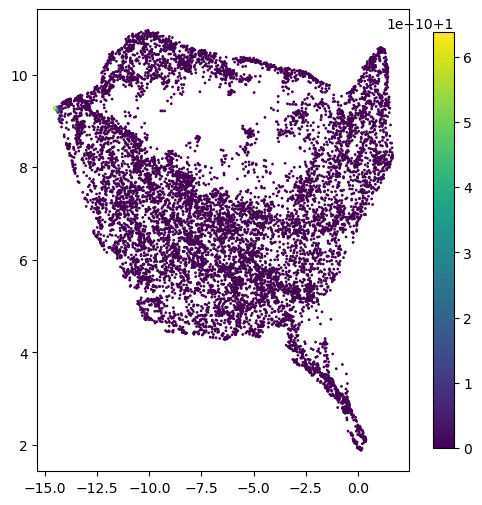

In [36]:
fig, ax = plt.subplots(figsize = (6,6))

c = np.exp(g)
ci = np.argsort(c)
sax = ax.scatter(-xu[ci,0], xu[ci,1], s = 1, c = c[ci])

plt.colorbar(sax, shrink = 0.9)

In [43]:
c.min()

np.float64(1.0)

In [52]:
g_l

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([1.60982339e-15, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [37]:
gst = pd.read_csv('data/death_msigdb_kegg.csv', index_col=0)
birth_gst = [g for g in gst['gene_symbol'].unique() if g in data_all.var_names]

In [38]:

birth_gst

['Casp3', 'Csf2rb2', 'Cycs', 'Nfkbia']

In [39]:
gmx = pd.read_csv('../../Data/Mouse_scRNA_Data/new_gene_sets.gmx',sep="\t")

In [40]:
gmx

,Cell_cycle,Necroptosis,Pyroptosis
0,na,na,na
1,Spin2f,Aifm1,Aim2
2,Spin2e,Birc2,Casp1
3,Gm21637,Birc3,Casp4
4,Gm5926,Bok,Casp6
...,...,...,...
828,Hist1h1e,NaN,NaN
829,H3f3b,NaN,NaN
830,H2afz,NaN,NaN
831,Fzr1,NaN,NaN


In [41]:
birth_gst = [g for g in gmx['Necroptosis'].unique() if g in data_all.var_names]

In [42]:
birth_gst

['Parp1', 'Zbp1']

In [28]:
gmx['Cell_cycle']

0            na
1        Spin2f
2        Spin2e
3       Gm21637
4        Gm5926
         ...   
828    Hist1h1e
829       H3f3b
830       H2afz
831        Fzr1
832        Plk1
Name: Cell_cycle, Length: 833, dtype: object

In [29]:
gst['gene_symbol']

1       Aifm1
2        Akt1
3        Akt2
4        Akt3
5       Apaf1
       ...   
82    Tnfsf10
83      Trp53
84      Tradd
85      Traf2
86       Xiap
Name: gene_symbol, Length: 86, dtype: object